# Machine Learning and NLP on Review Dataset #

## Introduction ##

We will be using the review data set from Kaggle for this exercise. The product we'll focus on this time is a cappuccino cup. The goal of this week is to not only preprocess the data, but to classify reviews as positive or negative based on the review text.

In [15]:
import nltk
import pandas as pd
import numpy as np
import re
import string
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

In [16]:
data = pd.read_csv('coffee.csv')
data.head()

,user_id,stars,reviews
0,A2XP9IN4JOMROD,1,I wanted to love this. I was even prepared for...
1,A2TS09JCXNV1VD,5,Grove Square Cappuccino Cups were excellent. T...
2,AJ3L5J7GN09SV,2,I bought the Grove Square hazelnut cappuccino ...
3,A3CZD34ZTUJME7,1,"I love my Keurig, and I love most of the Keuri..."
4,AWKN396SHAQGP,1,It's a powdered drink. No filter in k-cup.<br ...


## Question 1 ##

* Determine how many reviews there are in total.
* Determine the percent of 1, 2, 3, 4 and 5 star reviews.
* Create a new data set for modeling with the following columns:
     - Column 1: 'positive' if review = 4 or 5, and 'negative' if review = 1 or 2
     - Column 2: review text
* Take a look at the number of positive and negative reviews in the newly created data set.

Checkpoint: the resulting data set should have 514 reviews.

Use the preprocessing code below to clean the reviews data before moving on to modeling.

In [3]:
# Number of reviews
len(data.reviews)

542

In [4]:
# Percentage distribution of star ratings
one_star = 0
two_star = 0
thr_star = 0
fou_star = 0
fiv_star = 0

for x in range(len(data.reviews)):
    if(data.stars[x]==1):
        one_star += 1
    elif(data.stars[x]==2):
        two_star += 1
    elif(data.stars[x]==3):
        thr_star += 1
    elif(data.stars[x]==4):
        fou_star += 1
    else:
        fiv_star += 1

print("Percentage of one_star : " + str(round((100 * float(one_star) / len(data.reviews)),2)))
print("Percentage of two_star : " + str(round((100 * float(two_star) / len(data.reviews)),2)))
print("Percentage of three_star : " + str(round((100 * float(thr_star) / len(data.reviews)),2)))
print("Percentage of four_star : " + str(round((100 * float(fou_star) / len(data.reviews)),2)))
print("Percentage of five_star : " + str(round((100 * float(fiv_star) / len(data.reviews)),2)))

Percentage of one_star : 17.71
Percentage of two_star : 8.3
Percentage of three_star : 5.17
Percentage of four_star : 11.99
Percentage of five_star : 56.83


In [5]:
# Create a new dataframe with ratings and reviews from the existing dataframe
data_mod = data[['stars','reviews']]
data_mod.columns = ['ratings', 'reviews']

for a in range(len(data_mod.reviews)):
    if(data_mod.ratings[a] < 3):
        data_mod.ratings[a] = 'negative'
    elif(data_mod.ratings[a] > 3):
        data_mod.ratings[a] = 'positive'

data_mod = data_mod[data_mod.ratings != 3]
len(data_mod.reviews)

/Users/champ/anaconda3/envs/AdvancedText/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/champ/anaconda3/envs/AdvancedText/lib/python2.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/champ/anaconda3/envs/AdvancedText/lib/python2.7/site-packages/pandas/core/series.py:1015: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc[

514

In [6]:
data_mod.head(10)

,ratings,reviews
0,negative,I wanted to love this. I was even prepared for...
1,positive,Grove Square Cappuccino Cups were excellent. T...
2,negative,I bought the Grove Square hazelnut cappuccino ...
3,negative,"I love my Keurig, and I love most of the Keuri..."
4,negative,It's a powdered drink. No filter in k-cup.<br ...
6,negative,don't bother! bet you couldn't tell the differ...
7,negative,"Never tasted this coffee before, I felt much t..."
8,negative,While the overall idea behind the product is l...
9,positive,I bought a keurig and bought these to try. Wel...
10,positive,My husband and I LOVE this French Vanilla Capp...


In [7]:
# Number of positive and negative reviews
data_mod.groupby('ratings').count()

,reviews
ratings,
negative,141
positive,373


In [17]:
# Text preprocessing steps - remove numbers, captial letters and punctuation

alphanumeric = lambda x: re.sub(r"""\w*\d\w*""", ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

data_mod['reviews'] = data_mod.reviews.map(alphanumeric).map(punc_lower)
data_mod.head()

,ratings,reviews
0,negative,i wanted to love this i was even prepared for...
1,positive,grove square cappuccino cups were excellent t...
2,negative,i bought the grove square hazelnut cappuccino ...
3,negative,i love my keurig and i love most of the keuri...
4,negative,it s a powdered drink no filter in k cup br ...


## Question 2 ##

Prepare the data for modeling:
* Split the data into training and test sets. You should have four sets of data - X_train, X_test, y_train, y_test

Create numerical features with Count Vectorizer. Create two document-term matrices:
* Matrix 1: Terms should be unigrams (single words), and values should be word counts (Hint: this is the Count Vectorizer default)
* Matrix 2: Terms should be unigrams and bigrams, and values should be binary values

Recommendation: Utilize Count Vectorizer's stop words function to remove stop words from the reviews text.

In [9]:
X = data_mod.reviews
y = data_mod.ratings
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(stop_words="english")

X_train_transformed = count_vectorizer.fit_transform(X_train)
X_test_transformed = count_vectorizer.transform(X_test)

print(X_train_transformed.toarray().shape)
df = pd.DataFrame(X_train_transformed.toarray(), columns = count_vectorizer.get_feature_names())
print(df)

(359, 1638)
     able  abomination  absolute  absolutely  acceptable  accident  actual  \
0       0            0         0           0           0         0       0   
1       0            0         0           0           0         0       0   
2       0            0         0           0           0         0       0   
3       0            0         0           0           0         0       0   
4       0            0         0           0           0         0       0   
5       0            0         0           0           0         0       0   
6       0            0         0           0           0         0       0   
7       0            0         0           0           0         0       0   
8       0            0         0           0           0         0       0   
9       0            0         0           0           0         0       0   
10      0            0         0           1           0         0       0   
11      0            0         0           0        

In [34]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.3, random_state=42)
count_vectorizer2 = CountVectorizer(ngram_range=(1, 2), stop_words="english")

X_train2_transformed = count_vectorizer2.fit_transform(X_train2)
X_test2_transformed = count_vectorizer2.transform(X_test2)

print(X_train2_transformed.toarray().shape)
df2 = pd.DataFrame(X_train2_transformed.toarray(), columns = count_vectorizer2.get_feature_names())
print(df2)

(359, 7792)
     able  able cappuccino  able drink  able finish  able longer  able make  \
0       0                0           0            0            0          0   
1       0                0           0            0            0          0   
2       0                0           0            0            0          0   
3       0                0           0            0            0          0   
4       0                0           0            0            0          0   
5       0                0           0            0            0          0   
6       0                0           0            0            0          0   
7       0                0           0            0            0          0   
8       0                0           0            0            0          0   
9       0                0           0            0            0          0   
10      0                0           0            0            0          0   
11      0                0           0  

## Question 3 ##

Use Logistic Regression to classify reviews as positive or negative. Do this for both matrices.
* Fit a Logistic Regression model on the training data
* Apply the model on the test data and calculate the following error metrics: accuracy, precision, recall, F1 score
* Optional: Visualize the confusion matrix for both models
* Compare the error metrics of the two matrices

Recommendation: Create a function to calculate the error metrics, since you'll be doing this multiple times.

In [36]:
# Logistic Regression model for one gram
lr = LogisticRegression()

# Training the model
lr.fit(X_train_transformed, y_train)

# Take the model that was trained on the X_train_transformed data and apply it to the X_test_transformed data
y_pred_cv_lr = lr.predict(X_test_transformed)
y_pred_cv_lr

array(['positive', 'positive', 'positive', 'positive', 'negative',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'negative',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'negative', 'positive', 'positive', 'negative', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'negative', 'positive', 'positive', 'positive',
       'negative', 'positive', 'positive', 'negative', 'negative',
       'positive', 'negative', 'negative', 'positive', 'positive',
       'positive', 'positive', 'positive', 'negative', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'negative', 'negative',
       'negative', 'positive', 'positive', 'negative', 'positi

Accuracy: 0.865
Precision: 0.9
Recall: 0.923
F1 Score: 0.911


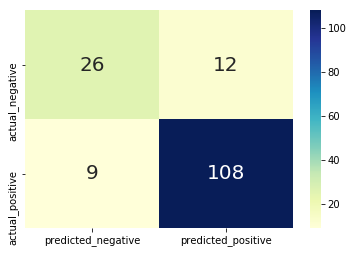

In [37]:
%matplotlib inline
cm = confusion_matrix(y_test, y_pred_cv_lr)
sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], yticklabels=['actual_negative', 'actual_positive'], annot=True, fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
true_neg, false_pos = cm[0]
false_neg, true_pos = cm[1]
accuracy = round(float((true_pos + true_neg)) / (true_pos + true_neg + false_pos + false_neg),3)
precision = round(float((true_pos)) / (true_pos + false_pos),3)
recall = round(float((true_pos)) / (true_pos + false_neg),3)
f1 = round(2 * (precision * recall) / (precision + recall),3)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F1 Score: {}'.format(f1))

In [38]:
# Logistic Regression model for bi grams
lr2 = LogisticRegression()

# Training the model
lr2.fit(X_train2_transformed, y_train2)

# Take the model that was trained on the X_train_transformed data and apply it to the X_test_transformed data
y_pred2_cv_lr = lr2.predict(X_test2_transformed)
y_pred2_cv_lr

array(['positive', 'positive', 'positive', 'positive', 'negative',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'negative',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'negative', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'negative', 'positive', 'positive', 'positive',
       'negative', 'positive', 'positive', 'negative', 'negative',
       'positive', 'negative', 'negative', 'positive', 'positive',
       'positive', 'positive', 'positive', 'negative', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'negative', 'negative',
       'negative', 'positive', 'positive', 'negative', 'positi

Accuracy: 0.865
Precision: 0.893
Recall: 0.932
F1 Score: 0.912


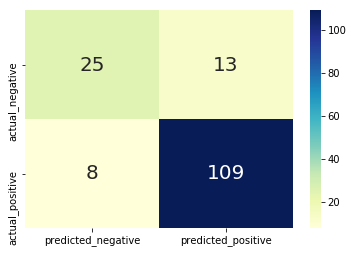

In [39]:
%matplotlib inline
cm2 = confusion_matrix(y_test2, y_pred2_cv_lr)
sns.heatmap(cm2, xticklabels=['predicted_negative', 'predicted_positive'], yticklabels=['actual_negative', 'actual_positive'], annot=True, fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
true_neg, false_pos = cm2[0]
false_neg, true_pos = cm2[1]
accuracy = round(float((true_pos + true_neg)) / (true_pos + true_neg + false_pos + false_neg),3)
precision = round(float((true_pos)) / (true_pos + false_pos),3)
recall = round(float((true_pos)) / (true_pos + false_neg),3)
f1 = round(2 * (precision * recall) / (precision + recall),3)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F1 Score: {}'.format(f1))

## Question 4 ##

Let's try using another machine learning technique to classify these reviews as positive or negative. Go through the exact same exercise in the previous step, except this time, use Naive Bayes instead of Logistic Regression.

For count data, use [Multinomial Naive Bayes](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB). For binary data, use [Bernoulli Naive Bayes](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB).

Compare the results of both the Logistic Regression and Naive Bayes models.

In [43]:
# Multinomial Naive Bayes model
nb = MultinomialNB()

# Train the model
nb.fit(X_train_transformed, y_train)

# Take the model that was trained on the X_train_transformed data and apply it to the X_test_transformed data
y_pred_cv_nb = nb.predict(X_test_transformed)
y_pred_cv_nb

array(['positive', 'positive', 'positive', 'positive', 'negative',
       'positive', 'negative', 'positive', 'positive', 'positive',
       'negative', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'negative',
       'positive', 'positive', 'positive', 'negative', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'negative', 'positive', 'positive', 'positive',
       'negative', 'positive', 'positive', 'positive', 'negative',
       'positive', 'negative', 'negative', 'positive', 'positive',
       'positive', 'positive', 'positive', 'negative', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'negative', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'negative',
       'positive', 'negative', 'positive', 'negative', 'positi

Accuracy: 0.884
Precision: 0.909
Recall: 0.94
F1 Score: 0.924


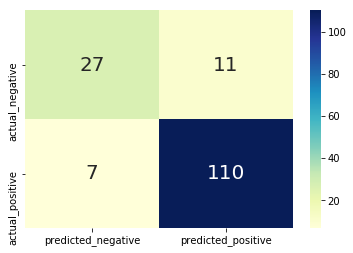

In [44]:
cm_nb = confusion_matrix(y_test, y_pred_cv_nb)
sns.heatmap(cm_nb, xticklabels=['predicted_negative', 'predicted_positive'], yticklabels=['actual_negative', 'actual_positive'], annot=True, fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
true_neg, false_pos = cm_nb[0]
false_neg, true_pos = cm_nb[1]
accuracy = round(float((true_pos + true_neg)) / (true_pos + true_neg + false_pos + false_neg),3)
precision = round(float((true_pos)) / (true_pos + false_pos),3)
recall = round(float((true_pos)) / (true_pos + false_neg),3)
f1 = round(2 * (precision * recall) / (precision + recall),3)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F1 Score: {}'.format(f1))

In [45]:
# Bernoulli Naive Bayes model
nb2 = BernoulliNB()

# Train the model
nb2.fit(X_train2_transformed, y_train2)

# Take the model that was trained on the X_train_cv data and apply it to the X_test_cv data
y_pred2_cv_nb = nb2.predict(X_test2_transformed)
y_pred2_cv_nb

array(['positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positive',
       'positive', 'positive', 'positive', 'positive', 'positi

Accuracy: 0.761
Precision: 0.76
Recall: 1.0
F1 Score: 0.864


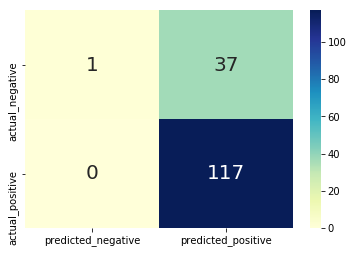

In [46]:
cm_nb2 = confusion_matrix(y_test2, y_pred2_cv_nb)
sns.heatmap(cm_nb2, xticklabels=['predicted_negative', 'predicted_positive'], yticklabels=['actual_negative', 'actual_positive'], annot=True, fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
true_neg, false_pos = cm_nb2[0]
false_neg, true_pos = cm_nb2[1]
accuracy = round(float((true_pos + true_neg)) / (true_pos + true_neg + false_pos + false_neg),3)
precision = round(float((true_pos)) / (true_pos + false_pos),3)
recall = round(float((true_pos)) / (true_pos + false_neg),3)
f1 = round(2 * (precision * recall) / (precision + recall),3)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F1 Score: {}'.format(f1))

**Comparing all the four models, it appeared to be Multinomial Naive Bayes model with one-grams generates the best result with highest precision and accuracy. Recall values are comparable for the models.

**Based on our need or priority for delection criteria, we can put importance on which factor to be considered for selecting a model.

## Question 5 ##

Up to this point, we've been using Count Vectorizer to create document-term matrices to input into the models. For at least one of the four models you've created so far, use TF-IDF Vectorizer instead of Count Vectorizer, and see if it improves the results.

Out of all of the models you've created, which model do you think best classifies positive and negative cappuccino cup reviews?

In [48]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.3, random_state=42)
tfidf = TfidfVectorizer(stop_words='english')
X_train3_tfidf = tfidf.fit_transform(X_train3)
X_test3_tfidf = tfidf.transform(X_test3)
TF_IDF = pd.DataFrame(X_train3_tfidf.toarray(), columns=tfidf.get_feature_names())

In [49]:
LRG = LogisticRegression()
LRG.fit(X_train3_tfidf, y_train3)
prediction = LRG.predict(X_test3_tfidf)

Accuracy: 0.845
Precision: 0.83
Recall: 1.0
F1 Score: 0.907


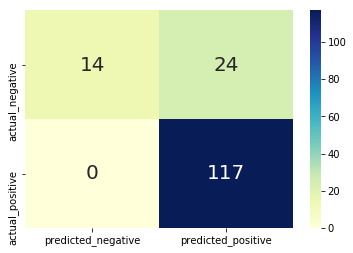

In [50]:
%matplotlib inline
cm3 = confusion_matrix(y_test3, prediction)
sns.heatmap(cm3, xticklabels=['predicted_negative', 'predicted_positive'], yticklabels=['actual_negative', 'actual_positive'], annot=True, fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
true_neg, false_pos = cm3[0]
false_neg, true_pos = cm3[1]
accuracy = round(float((true_pos + true_neg)) / (true_pos + true_neg + false_pos + false_neg),3)
precision = round(float((true_pos)) / (true_pos + false_pos),3)
recall = round(float((true_pos)) / (true_pos + false_neg),3)
f1 = round(2 * (precision * recall) / (precision + recall),3)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F1 Score: {}'.format(f1))

**In this particular case, TF-IDF doesn't improve the results. Overall in this case it seems, Multinomial Naive Bayes is the best performing model.